In [7]:
# Regulars
import pandas as pd
import numpy as np
import random
import copy
from scipy import stats
from datetime import datetime, timedelta
import re

# For plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import patches
import brewer2mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import pyplot
import matplotlib.ticker as mticker
import pylab

# For Alpha Vantage stock price extraction
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint

# For sentiment analysis
import textblob
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Time series and SKlearn
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import pyflux as pf
from sklearn import datasets, linear_model, neighbors, metrics
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.model_selection import train_test_split



# Section 1: Request Data

## Part 1: Stock Prices from Alpha Vantage
 - TESLA as an example


In [3]:
# Getting Data
ts = TimeSeries(key='8YU104T9GX7R3ATS', output_format='pandas')
tsla, tsla_data = ts.get_intraday(symbol='TSLA',interval='5min', outputsize='full')


In [4]:
# Getting percentage changes:
open_only = pd.DataFrame(tsla['1. open'])
pct = open_only.pct_change()

pct['pct'] = pct['1. open']*100
pct['pct'].dropna(inplace=True)

pct['time'] = pct.index
pct.reset_index(drop=True, inplace=True)


pct.dropna(inplace=True)

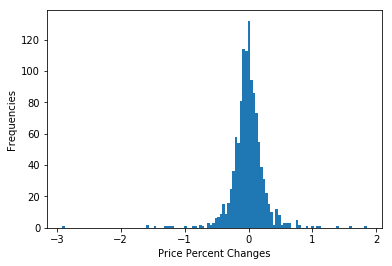

In [5]:
# Plotting Histgram
pct_lst= pct['pct'].values.tolist()

fig = plt.figure()

ax = fig.add_subplot(111)

ax.set_xlabel('Price Percent Changes')
ax.set_ylabel('Frequencies')

ax.hist(pct_lst, bins=120)
plt.show()

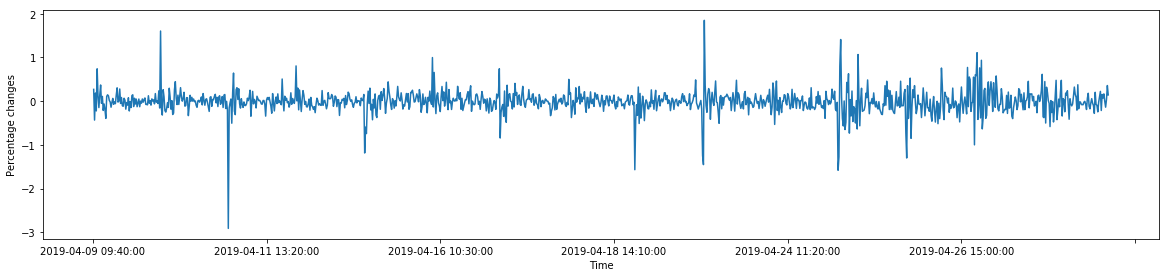

In [9]:
# Plotting time series
labels = list(pct['time'])

fig = plt.figure(figsize=(20, 16))
plt.subplots_adjust(hspace = 0.4) #Adjusting the space between subplots.

#Setting Subplots:
ax1 = fig.add_subplot(3, 1, 1)
plt1, = ax1.plot(pct['pct'])

# helper function for the formatter
def listifed_formatter(x, pos=None):
    try:
        return labels[int(x)]
    except IndexError:
        return ''

# make and use the formatter
mt = mticker.FuncFormatter(listifed_formatter)
ax1.xaxis.set_major_formatter(mt)

ax1.set_xlabel('Time')
ax1.set_ylabel('Percentage changes')

[lab.set_rotation(20) for lab in ax.get_xticklabels()]

plt.show()

## Part 2: Twitter data cleaning
 - Tweets were collected from SFM and saved as CSV.

### I. Fetch Tweets wih keywords functions:

1. fetch_tweet()
2. fetch_msft() - Using Micorsoft as an example
3. sentiment_analysis() - T1 method
4. textblob_polarity() - T2 method
5. vader_analysis() - V1 method
6. vader_analysis2() - V2 method

In [10]:
def fetch_tweet(time_frame):
    start, end = time_frames[time_frame]

    tweet = res_twt[
        (res_twt['parsed_created_at'] >= start) & 
        (res_twt['parsed_created_at'] <= end)
    ]
    
    cleaned = tweet[['parsed_created_at', 'text']]
    cleaned.reset_index(inplace=True, drop=True)
    
    return cleaned

def fetch_msft(tweet_collection):
    msft = tweet_collection[tweet_collection['text'].str.contains('Microsoft|microsoft|MSFT|msft') == True]
    msft.reset_index(inplace=True, drop=True)
    
    return msft

analyser = SentimentIntensityAnalyzer()

def sentiment_analysis(tweet_collection):
    def clean(t):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", t).split())


    tweet_collection['cleaned'] = tweet_collection['text'].apply(clean)
    
    def sentiment(tweet):
        analysis = TextBlob(tweet) 
        # set sentiment 
        if analysis.sentiment.polarity > 0.1: 
            return 1
        elif analysis.sentiment.polarity < 0: 
            return -1
        else: 
            return 0

    # sentiment(tesla0['cleaned'][te])
    tweet_collection['sentiment'] = tweet_collection['cleaned'].apply(sentiment)
    
    return tweet_collection
    
def textblob_polarity(tweet_collection):
    def clean(t):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", t).split())


    tweet_collection['cleaned'] = tweet_collection['text'].apply(clean)
    
    def sentiment(tweet):
        analysis = TextBlob(tweet) 
        # set sentiment 
        p = analysis.sentiment.polarity
        return p

    tweet_collection['sentiment_t'] = tweet_collection['cleaned'].apply(sentiment)
    
    return tweet_collection

def vader_analysis(tweet_collection):
    def clean(t):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", t).split())


    tweet_collection['cleaned'] = tweet_collection['text'].apply(clean)
    
    def sentiment_analyzer_scores(sentence):
        score = analyser.polarity_scores(sentence)
        # set sentiment 
        if score['compound'] < 0:
            return -1
        if score['compound'] > 0.2:
            return 1
        else:
            return 0

    tweet_collection['vader_sentiment'] = tweet_collection['cleaned'].apply(sentiment_analyzer_scores)
    
    return tweet_collection

def vader_analysis2(tweet_collection):
    def clean(t):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", t).split())

    tweet_collection['cleaned'] = tweet_collection['text'].apply(clean)
    
    def sentiment_analyzer_scores(sentence):
        score = analyser.polarity_scores(sentence)
        # set sentiment 
        return score['compound']

    tweet_collection['vader_sentiment2'] = tweet_collection['cleaned'].apply(sentiment_analyzer_scores)
    
    return tweet_collection

### Noted that to choose the thresholds to cut off the Textblob and Vader, a mannual gridsearch can be done. You can find the metrics used for the gridsearch at the end of this Section. 

### II. Create time frames: 5 minutes intervals

In [ ]:
def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta
        
time_frames = []
for d in (27, 28, 29): #March
    dts = [dt.strftime('%Y-%m-%d %H:%M:%S') for dt in 
    datetime_range(datetime(2019, 3, d, 9, 25), datetime(2019, 3, d, 16, 0), timedelta(minutes=5))]
#     time_frames.extend(dts)
    for i in range(len(dts)):
        if datetime.strptime(dts[i], '%Y-%m-%d %H:%M:%S').hour != 16:
            try:
                start = datetime.strptime(dts[i], '%Y-%m-%d %H:%M:%S')
                end = datetime.strptime(dts[i+1], '%Y-%m-%d %H:%M:%S')
                temp = [start, end]
                time_frames.append(temp)
            except:
                break

for d in [1,2,3,4,5,8,9,10, 11]: #April
    dts = [dt.strftime('%Y-%m-%d %H:%M:%S') for dt in 
    datetime_range(datetime(2019, 4, d, 9, 25), datetime(2019, 4, d, 16, 0), timedelta(minutes=5))]
    for i in range(len(dts)):
        if datetime.strptime(dts[i], '%Y-%m-%d %H:%M:%S').hour != 16:
            try:
                start = datetime.strptime(dts[i], '%Y-%m-%d %H:%M:%S')
                end = datetime.strptime(dts[i+1], '%Y-%m-%d %H:%M:%S')
                temp = [start, end]
                time_frames.append(temp)
            except:
                break                
                
print(len(time_frames))

### III. Read in CSV files

In [ ]:
temp0 = pd.read_csv("Pilot_short_0.csv", parse_dates = ['parsed_created_at'])
temp1 = pd.read_csv("Pilot_short_1.csv", parse_dates = ['parsed_created_at'])
temp2 = pd.read_csv("Pilot_short_2.csv", parse_dates = ['parsed_created_at'])
temp3 = pd.read_csv("Pilot_short_3.csv", parse_dates = ['parsed_created_at'])
temp4 = pd.read_csv("Pilot_short_4.csv", parse_dates = ['parsed_created_at'])
temp5 = pd.read_csv("Pilot_short_5.csv", parse_dates = ['parsed_created_at'])
temp6 = pd.read_csv("Pilot_short_6.csv", parse_dates = ['parsed_created_at'])
temp7 = pd.read_csv("Pilot_short_7.csv", parse_dates = ['parsed_created_at'])
temp8 = pd.read_csv("Pilot_short_8.csv", parse_dates = ['parsed_created_at'])


frames = [temp0, temp1, temp2, temp3, temp4, temp5, temp6, temp7, temp8]
res_twt = pd.concat(frames)
res_twt.reset_index(drop=True, inplace=True)

### III. Aggregated Twitter Sentiment 

In [ ]:
n = len(time_frames)

temp_frames = []
vader_frames = []
ratios = []
ratios_t = []
ratios_v = []
ratios_v2 = []

counts = []

for timeframe in range(0, n):
    temp = sentiment_analysis(fetch_msft(fetch_tweet(timeframe)))
#     temp_frames.append(temp)
    
    temp_t = textblob_polarity(fetch_msft(fetch_tweet(timeframe)))
    temp['sentiment_t'] = temp_t['sentiment_t']
    
    temp_v = vader_analysis(fetch_msft(fetch_tweet(timeframe)))
    temp['vader_sentiment'] = temp_v['vader_sentiment']
#     temp_frames.append(temp_v)
    
    temp_v2 = vader_analysis2(fetch_msft(fetch_tweet(timeframe)))
    temp['vader_sentiment2'] = temp_v2['vader_sentiment2']
    
    temp_frames.append(temp)
    
    c = len(temp['sentiment'])
    counts.append(c)
    
    if len(temp['sentiment']) != 0:
        sum_ = temp['sentiment'].sum()
        ratio = sum_/len(temp['sentiment'])
        ratios.append(ratio)
        counts.append(c)
        
        sum_ = temp_t['sentiment_t'].sum()
        ratio_t = sum_/len(temp['sentiment'])
        ratios_t.append(ratio_t)
        
        sum_ = temp_v['vader_sentiment'].sum()
        ratio_v = sum_/len(temp['sentiment'])
        ratios_v.append(ratio_v)
    
        sum_ = temp_v2['vader_sentiment2'].sum()
        ratio_v2 = sum_/len(temp['sentiment'])
        ratios_v2.append(ratio_v2)
    else:
        ratios.append(0)
        ratios_t.append(0)
        ratios_v.append(0)
        ratios_v2.append(0)
    
data_msft = pd.concat(temp_frames)
data_msft.reset_index(drop=True, inplace=True)

In [ ]:
# Gridsearch for thresholds
print(metrics.classification_report(textblob, vader1, target_names=["-1", "0", "1"]))

# Section 3: Intraday Model Construction

### Part 1: Get data for 03/27

In [ ]:
lst_0 = list(prices['msft'][:78])
lst_time = list(prices['time'][:78])
lst_sentiment = ratios[:78]
lst_t = ratios_t[:78]
lst_vader = ratios_v[:78]
lst_vader2 = ratios_v2[:78]

data = pd.DataFrame({"price": lst_0, "textblob": lst_sentiment, "textblob_t": lst_t, "vader": lst_vader, "vader2": lst_vader2, 'time': lst_time})
data.head()

### Part 2: Baseline Model
 - MLE as an example
 - Gridsearch ar

In [ ]:
# Gridsearch ar: 
ar = [6,7,8,9]
aic = []
for i in ar:
    model_vader0 = pf.ARIMA(data=data, ar=i, ma=1, family=pf.Normal())

    x0 = model_vader0.fit("MLE")
    temp0 = x0.aic
    aic.append(temp0)

# Find best ar:
df_ar = pd.DataFrame({"ar":ar, "aic":aic})
loc = df_ar['aic'].idxmin()
ar_chosen = df_ar['ar'].iloc[loc]

# Predict with best ar:
predicted_prices = []
for i in range(78, 156):
    model_baseline = pf.ARIMA(data=data.iloc[:i], ar=ar_chosen, ma=1, family=pf.Normal())
    x = model_baseline.fit("MLE")
    temp = model_baseline.predict(h=1)
    predicted_prices.append(temp.values.tolist()[0][0])

In [ ]:
# Prediction Vs True:
t = prices['msft'][78:156].values.tolist()

fig = plt.figure()

ax = fig.add_subplot(111)
# fig.subplots_adjust(top=0.85)
# ax.set_title('axes title')

ax.set_xlabel('Time')
ax.set_ylabel('Price Change Predictions')

ax.plot(t, c="blue", label='True Data')
ax.plot(pred, c="red", label = "Predicted")

ax.legend(loc='best')

plt.show()

In [ ]:
# Prediction:
my_model.plot_predict_is(h=24, fit_once=False, figsize=(15,5))

predict_every = my_model.predict_is(h=24, fit_once=False)
p_e_lst = predict_every['Series'].values.tolist()

rmse = sqrt(mean_squared_error(true, p_e_lst))
print('Test RMSE: %.3f' % rmse)

In [ ]:
# Fitting the model: with MLE
my_model = pf.ARIMA(data=data, ar=6, ma=1, family=pf.Normal())
print(my_model.latent_variables)

result = my_model.fit("MLE")
result.summary()

my_model.plot_fit()

my_model.plot_predict_is(h=24, fit_once=False, figsize=(15,5))

predict_every = my_model.predict_is(h=24, fit_once=False)
p_e_lst = predict_every['Series'].values.tolist()

rmse = sqrt(mean_squared_error(true, p_e_lst))
print('Test RMSE: %.3f' % rmse)

In [ ]:
# Plotting Predictions vs True price changes for Baseline Model:


### Part 3: ARIMAX model
Using T1 as an example, exchange "sentiment" in the ARIMAX formula to "sentiment_t" to calculate T2 method, "vader" to calculate V1 method, and "vader2" to calculate V2 method
 - MLE as an example, use "M-H" to substitute "MLE" to get results for M-H fitting. 

In [ ]:
# T1 M-H: Gridsearch on ar
ar = [4,5,6,7,8,9]
aic = []
# Find out best ar:
for i in ar:
    model_vader0 = pf.ARIMAX(data=data, formula='price~1+vader',
                  ar=i, ma=1, family=pf.Normal())
    x0 = model_vader0.fit("MLE")
    temp0 = x0.aic
    aic.append(temp0)
    
df_ar = pd.DataFrame({"ar":ar, "aic":aic})

# Find the min ar and extract the value:
loc = df_ar['aic'].idxmin()
ar_chosen = df_ar['ar'].iloc[loc]
ar_chosen

# Fit the model with chosen ar:
model= pf.ARIMAX(data=data, formula='price~1+vader',
                  ar=ar_chosen, ma=1, family=pf.Normal())
x = model.fit("MLE")

In [ ]:
# Plotting fittings:
model.plot_fit(figsize=(10,6))

In [ ]:
# Plotting predictions:
model.plot_predict_is(h=24, fit_once=False, figsize=(15,5))

predict_every = model.predict_is(h=24, fit_once=False)
p_e_lst = predict_every['price'].values.tolist()

rmse = sqrt(mean_squared_error(true, p_e_lst))
print('Test RMSE: %.3f' % rmse)

In [ ]:
# Predictions for the next day:
lst_0 = list(prices['msft'][78:156])
lst_time = list(prices['time'][78:156])
lst_sentiment = ratios[78:156]
lst_t = ratios_t[78:156]
lst_vader = ratios_v[78:156]
lst_vader2 = ratios_v2[78:156]

test = pd.DataFrame({"price": lst_0, "textblob": lst_sentiment, "textblob_t": lst_t, "vader": lst_vader, "vader2": lst_vader2, 'time': lst_time})
test.head()

In [ ]:
predicted_prices = []

# Need to left out the opening price change for Inter-day Model:
for i in range(1,78):
    temp = model_vader.predict(h=1, oos_data=test.iloc[i])
    predicted_prices.append(temp.values.tolist()[0][0])
    
predicted_prices

# Section 4: Inter-day Model

In [ ]:
# Read in interday data:
df = pd.read_csv("interday_0327_0411.csv")

# Create time frames for interdays:
d2728 = [datetime(2019, 3, 27, 16, 0).strftime('%Y-%m-%d %H:%M:%S'), datetime(2019, 3, 28, 9, 35).strftime('%Y-%m-%d %H:%M:%S')]
d2829 = [datetime(2019, 3, 28, 16, 0).strftime('%Y-%m-%d %H:%M:%S'), datetime(2019, 3, 29, 9, 35).strftime('%Y-%m-%d %H:%M:%S')]
d2901 = [datetime(2019, 3, 29, 16, 0).strftime('%Y-%m-%d %H:%M:%S'), datetime(2019, 4, 1, 9, 35).strftime('%Y-%m-%d %H:%M:%S')]
d0102 = [datetime(2019, 4, 1, 16, 0).strftime('%Y-%m-%d %H:%M:%S'), datetime(2019, 4, 2, 9, 35).strftime('%Y-%m-%d %H:%M:%S')]
d0203 = [datetime(2019, 4, 2, 16, 0).strftime('%Y-%m-%d %H:%M:%S'), datetime(2019, 4, 3, 9, 35).strftime('%Y-%m-%d %H:%M:%S')]
d0304 = [datetime(2019, 4, 3, 16, 0).strftime('%Y-%m-%d %H:%M:%S'), datetime(2019, 4, 4, 9, 35).strftime('%Y-%m-%d %H:%M:%S')]
d0405 = [datetime(2019, 4, 4, 16, 0).strftime('%Y-%m-%d %H:%M:%S'), datetime(2019, 4, 5, 9, 35).strftime('%Y-%m-%d %H:%M:%S')]
d0508 = [datetime(2019, 4, 5, 16, 0).strftime('%Y-%m-%d %H:%M:%S'), datetime(2019, 4, 8, 9, 35).strftime('%Y-%m-%d %H:%M:%S')]
d0809 = [datetime(2019, 4, 8, 16, 0).strftime('%Y-%m-%d %H:%M:%S'), datetime(2019, 4, 9, 9, 35).strftime('%Y-%m-%d %H:%M:%S')]
d0910 = [datetime(2019, 4, 9, 16, 0).strftime('%Y-%m-%d %H:%M:%S'), datetime(2019, 4, 10, 9, 35).strftime('%Y-%m-%d %H:%M:%S')]
d1011 = [datetime(2019, 4, 10, 16, 0).strftime('%Y-%m-%d %H:%M:%S'), datetime(2019, 4, 11, 9, 35).strftime('%Y-%m-%d %H:%M:%S')]


time_frames = [d2728, d2829, d2901, d0102, d0203, d0304, d0405,
              d0508, d0809, d0910, d1011]
time_frames

In [ ]:
# Fetch data for Inter-day model:
n = len(time_frames)

temp_frames = []
vader_frames = []
ratios = []
ratios_t = []
ratios_v = []
ratios_v2 = []

counts = []

for timeframe in range(0, n):
    temp = sentiment_analysis(fetch_msft(fetch_tweet(timeframe)))
#     temp_frames.append(temp)
    
    temp_t = textblob_polarity(fetch_msft(fetch_tweet(timeframe)))
    temp['sentiment_t'] = temp_t['sentiment_t']
    
    temp_v = vader_analysis(fetch_msft(fetch_tweet(timeframe)))
    temp['vader_sentiment'] = temp_v['vader_sentiment']
#     temp_frames.append(temp_v)
    
    temp_v2 = vader_analysis2(fetch_msft(fetch_tweet(timeframe)))
    temp['vader_sentiment2'] = temp_v2['vader_sentiment2']
    
    temp_frames.append(temp)
    
    c = len(temp['sentiment'])
    counts.append(c)
    
    if len(temp['sentiment']) != 0:
        sum_ = temp['sentiment'].sum()
        ratio = sum_/len(temp['sentiment'])
        ratios.append(ratio)
        counts.append(c)
        
        sum_ = temp_t['sentiment_t'].sum()
        ratio_t = sum_/len(temp['sentiment'])
        ratios_t.append(ratio_t)
        
        sum_ = temp_v['vader_sentiment'].sum()
        ratio_v = sum_/len(temp['sentiment'])
        ratios_v.append(ratio_v)
    
        sum_ = temp_v2['vader_sentiment2'].sum()
        ratio_v2 = sum_/len(temp['sentiment'])
        ratios_v2.append(ratio_v2)
    else:
        ratios.append(0)
        ratios_t.append(0)
        ratios_v.append(0)
        ratios_v2.append(0)
    
data_msft = pd.concat(temp_frames)
data_msft.reset_index(drop=True, inplace=True)

In [ ]:
# Put ratios into a DataFrame
df_ratios = pd.DataFrame(data = {"ratios": ratios, "ratios_t": ratios_t, 
                        "ratios_v": ratios_v, "ratios_v2": ratios_v2})
df_ratios.corr()

In [ ]:
# Plotting
fig = plt.figure()

ax = fig.add_subplot(111)
# fig.subplots_adjust(top=0.85)
# ax.set_title('axes title')

ax.set_xlabel('Price Changes')
ax.set_ylabel('Sentiment Ratios (Textblob)')

ax.scatter(prices, ratios)
plt.show()

### Noted that the inter-day model then be constructed in Excel since it is quicker. Then a model was chosen based on R-2 score.

# Section 5: Full Model

In [ ]:
# Define opening price change based on the Inter-day model
def opening(vader):
    y = -0.1058*vader*vader-0.0689*vader+0.3871
    return y


op = opening(0.383462532299741)

In [ ]:
# Plot Full Model Predictions Vs True data. 
pred = [op]+predicted_prices

t = test['price'].values.tolist()

fig = plt.figure()

ax = fig.add_subplot(111)
# fig.subplots_adjust(top=0.85)
# ax.set_title('axes title')

ax.set_xlabel('Time')
ax.set_ylabel('Price Change Predictions')

ax.plot(t, c="blue", label='True Data')
ax.plot(pred, c="red", label = "Predicted")

ax.legend(loc='best')

plt.show()

In [ ]:
# Calculate the RMSE:
print(sqrt(mean_squared_error(t, predicted_prices)))